In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from random import randint
from sklearn.metrics import r2_score
import random

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
import time

In [2]:
import copy as cp

In [3]:
############import data RotationX


# dfx = pd.read_csv('data/data_tracker1_pitch.csv',sep=',')
dfx = pd.read_csv('data/nonrigid_z_processed.csv',sep=',')
# dfx = pd.read_csv('RotationData/RotationalX.csv',sep=',')

dfx = dfx.dropna()


dfx.columns= ['y', 'x1', 'x2', 'x3','x4','x5','x6']
dfx=dfx[['x1','x2','x3','x4','x5','x6','y']]
dfx.head

<bound method NDFrame.head of            x1       x2       x3       x4       x5       x6        y
0     0.53509  0.80222  0.49035  0.65027  0.80600  0.49185  0.49029
1     0.53502  0.80210  0.49042  0.65016  0.80597  0.49191  0.49029
2     0.53469  0.80212  0.49027  0.64994  0.80608  0.49175  0.49008
3     0.53454  0.80215  0.49015  0.64975  0.80618  0.49169  0.49004
4     0.53441  0.80212  0.49009  0.64954  0.80617  0.49160  0.48992
...       ...      ...      ...      ...      ...      ...      ...
6930  0.23022  0.80790  0.48838  0.35057  0.80481  0.49071  0.49384
6931  0.23021  0.80788  0.48837  0.35072  0.80482  0.49065  0.49384
6932  0.23021  0.80785  0.48839  0.35073  0.80481  0.49067  0.49376
6933  0.23005  0.80784  0.48836  0.35074  0.80486  0.49065  0.49377
6934  0.23005  0.80783  0.48839  0.35072  0.80486  0.49067  0.49377

[6934 rows x 7 columns]>

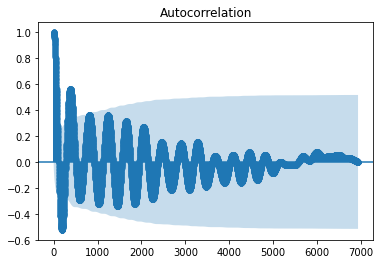

In [4]:
######autocorrelation 

from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt



x=dfx[["y"]]
#plot autocorrelation function
fig = tsaplots.plot_acf(x, lags=(len(dfx)-1))
plt.show()

In [5]:
###########add timestamp
N = len(dfx)


t = np.arange(0, N, 1).reshape(-1,1)
t = np.array([t[i] + np.random.rand(1)/4 for i in range(len(t))])
t = np.array([t[i] - np.random.rand(1)/7 for i in range(len(t))])
t = np.array(np.round(t, 2))

print(t)

[[-1.00000e-02]
 [ 1.12000e+00]
 [ 2.11000e+00]
 ...
 [ 6.93104e+03]
 [ 6.93209e+03]
 [ 6.93317e+03]]


In [6]:
#############combine timestamp with RotationX dataframe


dataset = pd.DataFrame(np.concatenate((t, dfx), axis=1), 
                       columns=['t','x1', 'x2', 'x3','x4','x5','x6','y'])

deltaT = np.array([(dataset.t[i + 1] - dataset.t[i]) for i in range(len(dataset)-1)])
deltaT = np.concatenate((np.array([0]), deltaT))

dataset.insert(1, '∆t', deltaT)


dataset.head(15)

,t,∆t,x1,x2,x3,x4,x5,x6,y
0,-0.01,0.00,0.53509,0.80222,0.49035,0.65027,0.80600,0.49185,0.49029
1,1.12,1.13,0.53502,0.80210,0.49042,0.65016,0.80597,0.49191,0.49029
2,2.11,0.99,0.53469,0.80212,0.49027,0.64994,0.80608,0.49175,0.49008
3,2.92,0.81,0.53454,0.80215,0.49015,0.64975,0.80618,0.49169,0.49004
4,4.10,1.18,0.53441,0.80212,0.49009,0.64954,0.80617,0.49160,0.48992
5,5.10,1.00,0.53417,0.80215,0.49006,0.64947,0.80610,0.49157,0.48987
6,6.08,0.98,0.53423,0.80214,0.49007,0.64946,0.80604,0.49158,0.48986
7,7.05,0.97,0.53418,0.80212,0.49013,0.64943,0.80601,0.49163,0.48995
8,8.06,1.01,0.53429,0.80210,0.49034,0.64948,0.80598,0.49183,0.49005
9,9.19,1.13,0.53439,0.80203,0.49047,0.64951,0.80602,0.49196,0.49013


In [7]:
############split dataset into training and testing sets

trainset = dataset.sample(frac=0.67, random_state=25)
testset = dataset.drop(trainset.index)
#trainset.head()
trainset.shape

(4646, 9)

In [8]:
############# linear model without window technique

from sklearn.ensemble import GradientBoostingRegressor
import time


gbr = GradientBoostingRegressor(random_state=0)

gbr.fit(trainset.iloc[:,:-1], trainset.iloc[:,-1])

t0 = time.time()
gbr_y = testset['y'].values
gbr_y_fit = gbr.predict(trainset.iloc[:,:-1])
gbr_y_pred = gbr.predict(testset.iloc[:,:-1])
tF = time.time()

gbr_residuals = gbr_y_pred - gbr_y
gbr_rmse = np.sqrt(np.sum(np.power(gbr_residuals,2)) / len(gbr_residuals))
print('RMSE = %.4f' % gbr_rmse)

RMSE = 0.0049


In [9]:
####### WindowSlider help function
ridge_rmse={}
ridge_rmse_list=[]
for m in range(100,(len(trainset) - 1),100):

    class WindowSlider(object):
        
        def __init__(self, window_size = m):        
            '''
            Window Slider object
            ====================
            w: window_size - number of time steps to look back
            o: offset between last reading and temperature
            r: response_size - number of time steps to predict
            l: maximum length to slide - (#observation - w)
            p: final predictors - (#predictors * w)
            '''
            self.w = window_size
            self.o = 0
            self.r = 1       
            self.l = 0
            self.p = 0
            self.names = []
        
        def re_init(self, arr):
            '''
            Helper function to initializate to 0 a vector
            '''
            arr = np.cumsum(arr)
            return arr - arr[0]
                

        def collect_windows(self, X, window_size=m, offset=0, previous_y=False):
            '''
            Input: X is the input matrix, each column is a variable
            Returns: diferent mappings window-output
            '''
            cols = len(list(X)) - 1
            N = len(X)
        
            self.o = offset
            self.w = window_size
            self.l = N - (self.w + self.r) + 1
            if not previous_y: self.p = cols * (self.w)
            if previous_y: self.p = (cols + 1) * (self.w)
        
            # Create the names of the variables in the window
            # Check first if we need to create that for the response itself
            if previous_y: x = cp.deepcopy(X)
            if not previous_y: x = X.drop(X.columns[-1], axis=1)  
        
            for j, col in enumerate(list(x)):        
                
                for i in range(self.w):
                
                    name = col + ('(%d)' % (i+1))
                    self.names.append(name)
        
            # Incorporate the timestamps where we want to predict
            for k in range(self.r):
            
                name = '∆t' + ('(%d)' % (self.w + k + 1))
                self.names.append(name)
            
            self.names.append('Y')
                
            df = pd.DataFrame(np.zeros(shape=(self.l, (self.p + self.r + 1))), 
                          columns=self.names)
        
            # Populate by rows in the new dataframe
            for i in range(self.l):
            
                slices = np.array([])
            
                # Flatten the lags of predictors
                for p in range(x.shape[1]):
            
                    line = X.values[i:self.w + i, p]
                    # Reinitialization at every window for ∆T
                    if p == 0: line = self.re_init(line)
                    
                    # Concatenate the lines in one slice    
                    slices = np.concatenate((slices, line)) 
 
                # Incorporate the timestamps where we want to predict
    
                line = np.array([self.re_init(X.values[i:i+self.w+self.r, 0])[-1]])
                y = np.array(X.values[self.w + i + self.r - 1, -1]).reshape(1,)
                slices = np.concatenate((slices, line, y))
            
                # Incorporate the slice to the cake (df)
                df.iloc[i,:] = slices
            
            return df
        
 
    w=m
    train_constructor = WindowSlider()
    train_windows = train_constructor.collect_windows(trainset.iloc[:,1:], 
                                                  previous_y=False)

    test_constructor = WindowSlider()
    test_windows = test_constructor.collect_windows(dataset.iloc[(len(trainset))-w:,1:],
                                                previous_y=False)
#     test_windows = test_constructor.collect_windows(testset.iloc[len(dfx)-w:,1:],
#                                                 previous_y=False)
    
#     print(test_windows.shape)

    train_constructor_y_inc = WindowSlider()
    train_windows_y_inc = train_constructor_y_inc.collect_windows(trainset.iloc[:,1:], 
                                                  previous_y=True)

    test_constructor_y_inc = WindowSlider()
    test_windows_y_inc = test_constructor_y_inc.collect_windows(dataset.iloc[(len(trainset))-w:,1:],
                                                previous_y=True)
#     test_windows_y_inc = test_constructor_y_inc.collect_windows(testset.iloc[len(dfx)-w:,1:],
#                                                 previous_y=True)

    #train_windows.head(3)
    #test_windows.head(3)
    
    ridge_model = Ridge()
    ridge_model.fit(train_windows.iloc[:,:-1], train_windows.iloc[:,-1])



    t0 = time.time()
    ridge_y = test_windows['Y'].values
    ridge_y_fit = ridge_model.predict(train_windows.iloc[:,:-1])
    ridge_y_pred = ridge_model.predict(test_windows.iloc[:,:-1])
    tF = time.time()

    ridge_residuals = ridge_y_pred - ridge_y
    ridge_rmse[m] = np.sqrt(np.sum(np.power(ridge_residuals,2)) / len(ridge_residuals))
    ridge_rmse_list.append(ridge_rmse[m])
    
print(ridge_rmse_list)       

[0.20507903532358504, 0.19715955627443327, 0.18327435298933886, 0.21307945832420852, 0.28158493113061583, 0.26058029768040675, 0.2796236152460563, 0.2988786226486847, 0.2976193162428108, 0.30103878008663754, 0.629452089985572, 0.6542570530608557, 0.666761807308373, 0.49412677409490113, 0.4855361522371318, 0.5925999559861357, 0.43896524593400843, 0.36204453028367245, 0.312991445560152, 0.30443318497248245, 0.2761304986795941, 0.26704568841921017, 0.2650329015479121, 0.25984209218069315, 0.30517319664553755, 0.23726892554588003, 0.22707766893430176, 0.22097166657220835, 0.2301857713621277, 0.2261590867299458, 0.20805433796854383, 0.20390629811861471, 0.1965228077121582, 0.19647235163571894, 0.19406257771081425, 0.18972807448884904, 0.18855482348498984, 0.1870943372792673, 0.18453972764479168, 0.21397342718968632, 0.17973258038461326, 0.17938896677771152, 0.18059131390834376, 0.17672233740955556, 0.17378169493641302, 0.18570286344581863]


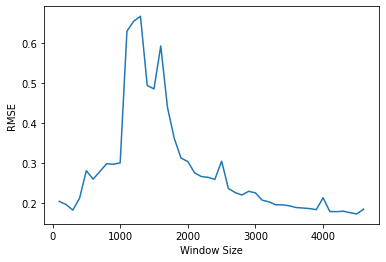

In [10]:
x_ridge=range(100,(len(trainset)-1),100)

y_ridge=ridge_rmse_list

plt.plot(x_ridge, y_ridge, label = "Ridge Regression")

  
# naming the x axis
plt.xlabel('Window Size')
# naming the y axis
plt.ylabel('RMSE')

  
# function to show the plot

plt.show()

In [11]:
# ####### WindowSlider help function
# br_rmse={}
# br_rmse_list=[]
# for m in range(100,(len(trainset)-1),100):

#     class WindowSlider(object):
        
#         def __init__(self, window_size = m):        
#             '''
#             Window Slider object
#             ====================
#             w: window_size - number of time steps to look back
#             o: offset between last reading and temperature
#             r: response_size - number of time steps to predict
#             l: maximum length to slide - (#observation - w)
#             p: final predictors - (#predictors * w)
#             '''
#             self.w = window_size
#             self.o = 0
#             self.r = 1       
#             self.l = 0
#             self.p = 0
#             self.names = []
        
#         def re_init(self, arr):
#             '''
#             Helper function to initializate to 0 a vector
#             '''
#             arr = np.cumsum(arr)
#             return arr - arr[0]
                

#         def collect_windows(self, X, window_size=m, offset=0, previous_y=False):
#             '''
#             Input: X is the input matrix, each column is a variable
#             Returns: diferent mappings window-output
#             '''
#             cols = len(list(X)) - 1
#             N = len(X)
        
#             self.o = offset
#             self.w = window_size
#             self.l = N - (self.w + self.r) + 1
#             if not previous_y: self.p = cols * (self.w)
#             if previous_y: self.p = (cols + 1) * (self.w)
        
#             # Create the names of the variables in the window
#             # Check first if we need to create that for the response itself
#             if previous_y: x = cp.deepcopy(X)
#             if not previous_y: x = X.drop(X.columns[-1], axis=1)  
        
#             for j, col in enumerate(list(x)):        
                
#                 for i in range(self.w):
                
#                     name = col + ('(%d)' % (i+1))
#                     self.names.append(name)
        
#             # Incorporate the timestamps where we want to predict
#             for k in range(self.r):
            
#                 name = '∆t' + ('(%d)' % (self.w + k + 1))
#                 self.names.append(name)
            
#             self.names.append('Y')
                
#             df = pd.DataFrame(np.zeros(shape=(self.l, (self.p + self.r + 1))), 
#                           columns=self.names)
        
#             # Populate by rows in the new dataframe
#             for i in range(self.l):
            
#                 slices = np.array([])
            
#                 # Flatten the lags of predictors
#                 for p in range(x.shape[1]):
            
#                     line = X.values[i:self.w + i, p]
#                     # Reinitialization at every window for ∆T
#                     if p == 0: line = self.re_init(line)
                    
#                     # Concatenate the lines in one slice    
#                     slices = np.concatenate((slices, line)) 
 
#                 # Incorporate the timestamps where we want to predict
    
#                 line = np.array([self.re_init(X.values[i:i+self.w+self.r, 0])[-1]])
#                 y = np.array(X.values[self.w + i + self.r - 1, -1]).reshape(1,)
#                 slices = np.concatenate((slices, line, y))
            
#                 # Incorporate the slice to the cake (df)
#                 df.iloc[i,:] = slices
            
#             return df
        
 
#     w=m
#     print(len(trainset))
#     train_constructor = WindowSlider()
#     train_windows = train_constructor.collect_windows(trainset.iloc[:,1:], 
#                                                   previous_y=False)

#     test_constructor = WindowSlider()
#     test_windows = test_constructor.collect_windows(dataset.iloc[(len(trainset))-w:,1:],
#                                                 previous_y=False)

#     train_constructor_y_inc = WindowSlider()
#     train_windows_y_inc = train_constructor_y_inc.collect_windows(trainset.iloc[:,1:], 
#                                                   previous_y=True)

#     test_constructor_y_inc = WindowSlider()
#     test_windows_y_inc = test_constructor_y_inc.collect_windows(dataset.iloc[(len(trainset))-w:,1:],
#                                                 previous_y=True)

#     #train_windows.head(3)
#     #test_windows.head(3)
    
#     br_model = BayesianRidge()
#     br_model.fit(train_windows.iloc[:,:-1], train_windows.iloc[:,-1])



#     t0 = time.time()
#     br_y = test_windows['Y'].values
#     br_y_fit = br_model.predict(train_windows.iloc[:,:-1])
#     br_y_pred = br_model.predict(test_windows.iloc[:,:-1])
#     tF = time.time()

#     br_residuals = br_y_pred - br_y
#     br_rmse[m] = np.sqrt(np.sum(np.power(br_residuals,2)) / len(br_residuals))
#     br_rmse_list.append(br_rmse[m])
    
# print(br_rmse_list)  

In [12]:
# x_br=range(100,(len(trainset)-1),100)

# y_br=br_rmse_list

# plt.plot(x_br, y_br, label = "Bayesian Ridge")

  
# # naming the x axis
# plt.xlabel('Window Size')
# # naming the y axis
# plt.ylabel('RMSE')

  
# # function to show the plot

# plt.show()

In [13]:
# ####### WindowSlider help function
# dt_rmse={}
# dt_rmse_list=[]
# for m in range(100,(len(trainset)-1),100):

#     class WindowSlider(object):
        
#         def __init__(self, window_size = m):        
#             '''
#             Window Slider object
#             ====================
#             w: window_size - number of time steps to look back
#             o: offset between last reading and temperature
#             r: response_size - number of time steps to predict
#             l: maximum length to slide - (#observation - w)
#             p: final predictors - (#predictors * w)
#             '''
#             self.w = window_size
#             self.o = 0
#             self.r = 1       
#             self.l = 0
#             self.p = 0
#             self.names = []
        
#         def re_init(self, arr):
#             '''
#             Helper function to initializate to 0 a vector
#             '''
#             arr = np.cumsum(arr)
#             return arr - arr[0]
                

#         def collect_windows(self, X, window_size=m, offset=0, previous_y=False):
#             '''
#             Input: X is the input matrix, each column is a variable
#             Returns: diferent mappings window-output
#             '''
#             cols = len(list(X)) - 1
#             N = len(X)
        
#             self.o = offset
#             self.w = window_size
#             self.l = N - (self.w + self.r) + 1
#             if not previous_y: self.p = cols * (self.w)
#             if previous_y: self.p = (cols + 1) * (self.w)
        
#             # Create the names of the variables in the window
#             # Check first if we need to create that for the response itself
#             if previous_y: x = cp.deepcopy(X)
#             if not previous_y: x = X.drop(X.columns[-1], axis=1)  
        
#             for j, col in enumerate(list(x)):        
                
#                 for i in range(self.w):
                
#                     name = col + ('(%d)' % (i+1))
#                     self.names.append(name)
        
#             # Incorporate the timestamps where we want to predict
#             for k in range(self.r):
            
#                 name = '∆t' + ('(%d)' % (self.w + k + 1))
#                 self.names.append(name)
            
#             self.names.append('Y')
                
#             df = pd.DataFrame(np.zeros(shape=(self.l, (self.p + self.r + 1))), 
#                           columns=self.names)
        
#             # Populate by rows in the new dataframe
#             for i in range(self.l):
            
#                 slices = np.array([])
            
#                 # Flatten the lags of predictors
#                 for p in range(x.shape[1]):
            
#                     line = X.values[i:self.w + i, p]
#                     # Reinitialization at every window for ∆T
#                     if p == 0: line = self.re_init(line)
                    
#                     # Concatenate the lines in one slice    
#                     slices = np.concatenate((slices, line)) 
 
#                 # Incorporate the timestamps where we want to predict
    
#                 line = np.array([self.re_init(X.values[i:i+self.w+self.r, 0])[-1]])
#                 y = np.array(X.values[self.w + i + self.r - 1, -1]).reshape(1,)
#                 slices = np.concatenate((slices, line, y))
            
#                 # Incorporate the slice to the cake (df)
#                 df.iloc[i,:] = slices
            
#             return df
        
 
#     w=m
#     train_constructor = WindowSlider()
#     train_windows = train_constructor.collect_windows(trainset.iloc[:,1:], 
#                                                   previous_y=False)

#     test_constructor = WindowSlider()
#     test_windows = test_constructor.collect_windows(dataset.iloc[len(trainset)-w:,1:],
#                                                 previous_y=False)

#     train_constructor_y_inc = WindowSlider()
#     train_windows_y_inc = train_constructor_y_inc.collect_windows(trainset.iloc[:,1:], 
#                                                   previous_y=True)

#     test_constructor_y_inc = WindowSlider()
#     test_windows_y_inc = test_constructor_y_inc.collect_windows(dataset.iloc[len(trainset)-w:,1:],
#                                                 previous_y=True)

#     #train_windows.head(3)
#     #test_windows.head(3)
    
#     dt_model = DecisionTreeRegressor()
#     dt_model.fit(train_windows.iloc[:,:-1], train_windows.iloc[:,-1])



#     t0 = time.time()
#     dt_y = test_windows['Y'].values
#     dt_y_fit = dt_model.predict(train_windows.iloc[:,:-1])
#     dt_y_pred = dt_model.predict(test_windows.iloc[:,:-1])
#     tF = time.time()

#     dt_residuals = dt_y_pred - dt_y
#     dt_rmse[m] = np.sqrt(np.sum(np.power(dt_residuals,2)) / len(dt_residuals))
#     dt_rmse_list.append(dt_rmse[m])
    
# print(dt_rmse_list)  

In [14]:
# x_dt=range(100,(len(trainset)-1),100)

# y_dt=dt_rmse_list

# plt.plot(x_dt, y_dt, label = "Decision Tree")

  
# # naming the x axis
# plt.xlabel('Window Size')
# # naming the y axis
# plt.ylabel('RMSE')

  
# # function to show the plot

# plt.show()

In [15]:
#######GBR

####### WindowSlider help function
gbr_rmse={}
gbr_rmse_list=[]
for m in range(100,(len(trainset)-1),2500):

    class WindowSlider(object):
        
        def __init__(self, window_size = m):        
            '''
            Window Slider object
            ====================
            w: window_size - number of time steps to look back
            o: offset between last reading and temperature
            r: response_size - number of time steps to predict
            l: maximum length to slide - (#observation - w)
            p: final predictors - (#predictors * w)
            '''
            self.w = window_size
            self.o = 0
            self.r = 1       
            self.l = 0
            self.p = 0
            self.names = []
        
        def re_init(self, arr):
            '''
            Helper function to initializate to 0 a vector
            '''
            arr = np.cumsum(arr)
            return arr - arr[0]
                

        def collect_windows(self, X, window_size=m, offset=0, previous_y=False):
            '''
            Input: X is the input matrix, each column is a variable
            Returns: diferent mappings window-output
            '''
            cols = len(list(X)) - 1
            N = len(X)
        
            self.o = offset
            self.w = window_size
            self.l = N - (self.w + self.r) + 1
            if not previous_y: self.p = cols * (self.w)
            if previous_y: self.p = (cols + 1) * (self.w)
        
            # Create the names of the variables in the window
            # Check first if we need to create that for the response itself
            if previous_y: x = cp.deepcopy(X)
            if not previous_y: x = X.drop(X.columns[-1], axis=1)  
        
            for j, col in enumerate(list(x)):        
                
                for i in range(self.w):
                
                    name = col + ('(%d)' % (i+1))
                    self.names.append(name)
        
            # Incorporate the timestamps where we want to predict
            for k in range(self.r):
            
                name = '∆t' + ('(%d)' % (self.w + k + 1))
                self.names.append(name)
            
            self.names.append('Y')
                
            df = pd.DataFrame(np.zeros(shape=(self.l, (self.p + self.r + 1))), 
                          columns=self.names)
        
            # Populate by rows in the new dataframe
            for i in range(self.l):
            
                slices = np.array([])
            
                # Flatten the lags of predictors
                for p in range(x.shape[1]):
            
                    line = X.values[i:self.w + i, p]
                    # Reinitialization at every window for ∆T
                    if p == 0: line = self.re_init(line)
                    
                    # Concatenate the lines in one slice    
                    slices = np.concatenate((slices, line)) 
 
                # Incorporate the timestamps where we want to predict
    
                line = np.array([self.re_init(X.values[i:i+self.w+self.r, 0])[-1]])
                y = np.array(X.values[self.w + i + self.r - 1, -1]).reshape(1,)
                slices = np.concatenate((slices, line, y))
            
                # Incorporate the slice to the cake (df)
                df.iloc[i,:] = slices
            
            return df
        
 
    w=m
    train_constructor = WindowSlider()
    train_windows = train_constructor.collect_windows(trainset.iloc[:,1:], 
                                                  previous_y=False)

    test_constructor = WindowSlider()
    test_windows = test_constructor.collect_windows(dataset.iloc[len(trainset)-w:,1:],
                                                previous_y=False)

    train_constructor_y_inc = WindowSlider()
    train_windows_y_inc = train_constructor_y_inc.collect_windows(trainset.iloc[:,1:], 
                                                  previous_y=True)

    test_constructor_y_inc = WindowSlider()
    test_windows_y_inc = test_constructor_y_inc.collect_windows(dataset.iloc[len(trainset)-w:,1:],
                                                previous_y=True)

    #train_windows.head(3)
    #test_windows.head(3)
    
    gbr_model = GradientBoostingRegressor()
    gbr_model.fit(train_windows.iloc[:,:-1], train_windows.iloc[:,-1])



    t0 = time.time()
    gbr_y = test_windows['Y'].values
    gbr_y_fit = gbr_model.predict(train_windows.iloc[:,:-1])
    gbr_y_pred = gbr_model.predict(test_windows.iloc[:,:-1])
    tF = time.time()

    gbr_residuals = gbr_y_pred - gbr_y
    gbr_rmse[m] = np.sqrt(np.sum(np.power(gbr_residuals,2)) / len(gbr_residuals))
    gbr_rmse_list.append(gbr_rmse[m])
    print(gbr_rmse[m])
    
print(gbr_rmse_list)  

0.18588075212910496
0.17211130332875127
[0.18588075212910496, 0.17211130332875127]


ValueError: x and y must have same first dimension, but have shapes (46,) and (2,)

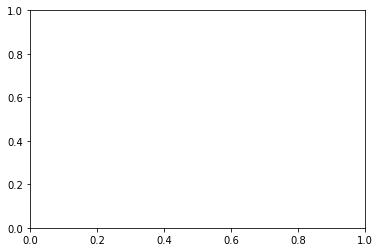

In [16]:
x_gbr=range(100,(len(trainset)-1),100)

y_gbr=gbr_rmse_list

plt.plot(x_gbr, y_gbr, label = "Gradient Boosting Regressor")

  
# naming the x axis
plt.xlabel('Window Size')
# naming the y axis
plt.ylabel('RMSE')

  
# function to show the plot

plt.show()

In [ ]:
######autocorrelation 

from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt



x=dfx[["y"]]
#plot autocorrelation function
fig = tsaplots.plot_acf(x, lags=(len(dfx)-1))
plt.show()

In [ ]:
################# GBR
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=0)

gbr.fit(train_windows.iloc[:,:-1], train_windows.iloc[:,-1])

t0 = time.time()
gbr_y = test_windows['Y'].values
gbr_y_fit = gbr.predict(train_windows.iloc[:,:-1])
gbr_y_pred = gbr.predict(test_windows.iloc[:,:-1])
tF = time.time()

gbr_residuals = gbr_y_pred - gbr_y
gbr_rmse = np.sqrt(np.sum(np.power(gbr_residuals,2)) / len(gbr_residuals))
print('RMSE = %.4f' % gbr_rmse)